### This notebook parses GWAS summary statistics and generates 3D Manhattan plots
#### `holoviews` version

In [1]:
import holoviews
import os
import pandas

%load_ext holoviews.ipython
%output backend='matplotlib' holomap='widgets'

### Parse data and set up axes properties:

In [2]:
GWADataPath = 'Data'
TmpPath = 'Tmp'

In [3]:
FName = 'TraitAttributesDF.pckl'
TraitAttributesDF = None
if(os.path.exists(os.path.join(GWADataPath,
                               FName))):
    TraitAttributesDF = pandas.read_pickle(
         os.path.join(GWADataPath,
                      FName))
    del FName
else:
    FName = 'ENGAGEBioCratesMetaboliteClasses.tsv'
    TraitAttributesDF = pandas.read_csv(os.path.join(GWADataPath,
                                                     FName),
                                        index_col=None,
                                        sep='\t')
    TraitAttributesDF.rename(columns={'# P': 'Index'},
                             inplace=True)
    del FName

    TraitFNameDF = pandas.DataFrame(data=os.listdir(GWADataPath),
                                    columns=['FName'])
    TraitFNameDF.insert(loc=0,
                        column='Path',
                        value=GWADataPath)
    Filter = TraitFNameDF['FName'].str.endswith('.csv')
    TraitFNameDF = TraitFNameDF[Filter].copy()
    del Filter
    TraitFNameDF.reset_index(drop=True,
                             inplace=True)
    TraitFNameDF.insert(loc=0,
                        column='Trait',
                        value=TraitFNameDF['FName'].str.split('_',
                                                              expand=True)[2])
    TraitAttributesDF = TraitAttributesDF.merge(
        right=TraitFNameDF,
        left_on='ENGAGEName',
        right_on='Trait',
        how='right')
    del TraitFNameDF
    TraitAttributesDF['Index'] = TraitAttributesDF.index.values + 1

    FName = 'TraitAttributesDF.pckl'
    TraitAttributesDF.to_pickle(os.path.join(TmpPath,
                                             FName))
    TraitAttributesDF.to_pickle(os.path.join(GWADataPath,
                                             FName))
    del FName

In [4]:
FName = 'GWASummaryStatisticsDF.pckl'
GWASummaryStatisticsDF = None
AxesDF = None
if(os.path.exists(os.path.join(GWADataPath,
                               FName))):
    GWASummaryStatisticsDF = pandas.read_pickle(
         os.path.join(TmpPath,
                      FName))
    del FName
    FName = 'AxesDF.pckl'
    AxesDF = pandas.read_pickle(
         os.path.join(GWADataPath,
                      FName))
    del FName
else:
    GWASummaryStatisticsDF = pandas.DataFrame(columns=['Trait',
                                                       'MarkerName',
                                                       'Allele1',
                                                       'Allele2',
                                                       'Freq1',
                                                       'FreqSE',
                                                       'MinFreq',
                                                       'MaxFreq',
                                                       'Effect',
                                                       'StdErr',
                                                       'P-value',
                                                       'Direction',
                                                       'HetISq',
                                                       'HetChiSq',
                                                       'HetDf',
                                                       'HetPVal'])
    for i in TraitAttributesDF.index:
        Trait = TraitAttributesDF.loc[i,
                                      'Trait']
        TmpDF = pandas.read_csv(
            os.path.join(TraitAttributesDF.loc[i,
                                               'Path'],
                         TraitAttributesDF.loc[i,
                                               'FName']),
            index_col=None,
            sep=',')
        TmpDF.insert(loc=0,
                     column='Trait',
                     value=Trait)
        GWASummaryStatisticsDF = GWASummaryStatisticsDF.append(TmpDF) 
        del TmpDF
    GWASummaryStatisticsDF['Allele1'] = GWASummaryStatisticsDF['Allele1'].str.upper()
    GWASummaryStatisticsDF['Allele2'] = GWASummaryStatisticsDF['Allele2'].str.upper()
    GWASummaryStatisticsDF.insert(loc=0,
                                  column='Index',
                                  value=GWASummaryStatisticsDF.index.values)
    
    FName = 'SNPInfo_MergedCorrected.txt.gz'
    VariantInfoDF = pandas.read_csv(os.path.join(GWADataPath,
                                                 FName),
                                    index_col=None,
                                    sep=' ')
    del FName
    
    GWASummaryStatisticsDF = GWASummaryStatisticsDF.merge(
        right=VariantInfoDF,
        left_on='MarkerName',
        right_on='SNPID',
        how='left')
    
    GWASummaryStatisticsDF.insert(loc=5,
                                  column='Pos',
                                  value=GWASummaryStatisticsDF['position'].values)
    GWASummaryStatisticsDF.insert(loc=5,
                                  column='Chr',
                                  value=GWASummaryStatisticsDF['chr'].values)
    GWASummaryStatisticsDF.insert(
        loc=14,
        column='pP-value',
        value=-pandas.np.real(
            pandas.np.log10(
                GWASummaryStatisticsDF['P-value'])))
    GWASummaryStatisticsDF.drop(labels=['SNPID',
                                        'chr',
                                        'position'],
                                axis=1,
                                inplace=True)

    AxesDict = {}

    AxesDict['Chr'] = {}
    AxesDict['Chr']['Label'] = 'Chromosome'
    Chromosomes = VariantInfoDF['chr'].unique()
    Chromosomes.sort()
    Offset = 10000
    AxesDict['Chr']['Min'] = float(VariantInfoDF.loc[
            VariantInfoDF['chr']==Chromosomes[0],
            'position'].min() - Offset)
    AxesDict['Chr']['MajorTickRotation'] = 0
    AxesDict['Chr']['MajorTickLabels'] = []
    AxesDict['Chr']['MajorTickLabels'].append('')
    AxesDict['Chr']['MajorTickPositions'] = []
    AxesDict['Chr']['MajorTickPositions'].append(AxesDict['Chr']['Min'])
    AxesDict['Chr']['MinorTickRotation'] = 90
    AxesDict['Chr']['MinorTickLabels'] = []
    AxesDict['Chr']['MinorTickPositions'] = []
    for i in xrange(1,
                    len(Chromosomes)):
        Chr = Chromosomes[i]
        AxesDict['Chr']['MajorTickLabels'].append('')
        AxesDict['Chr']['MajorTickPositions'].append(
            AxesDict['Chr']['MajorTickPositions'][-1] + 
            2.0*Offset +
            float(VariantInfoDF.loc[
                      VariantInfoDF['chr']==Chromosomes[i-1],
                      'position'].max() -
                  VariantInfoDF.loc[
                      VariantInfoDF['chr']==Chromosomes[i-1],
                      'position'].min()))
        AxesDict['Chr']['MinorTickLabels'].append(str(Chromosomes[i-1]))
        Range = AxesDict['Chr']['MajorTickPositions'][-1] - \
            AxesDict['Chr']['MajorTickPositions'][-2]
        AxesDict['Chr']['MinorTickPositions'].append(
            AxesDict['Chr']['MajorTickPositions'][-2] + 
            0.5*Range)  
    AxesDict['Chr']['MajorTickLabels'].append('')
    AxesDict['Chr']['MajorTickPositions'].append(
        AxesDict['Chr']['MajorTickPositions'][-1] + 
        2.0*Offset +
        float(VariantInfoDF.loc[
                  VariantInfoDF['chr']==Chromosomes[-1],
                  'position'].max() -
              VariantInfoDF.loc[
                  VariantInfoDF['chr']==Chromosomes[-1],
                  'position'].min()))
    AxesDict['Chr']['MinorTickLabels'].append(str(Chromosomes[-1]))
    Range = AxesDict['Chr']['MajorTickPositions'][-1] - \
        AxesDict['Chr']['MajorTickPositions'][-2]
    AxesDict['Chr']['MinorTickPositions'].append(
        AxesDict['Chr']['MajorTickPositions'][-2] + 
        0.5*Range)
    AxesDict['Chr']['Max'] = AxesDict['Chr']['MajorTickPositions'][-1]

    AxesDict['Trait'] = {}
    AxesDict['Trait']['Label'] = 'Trait'
    AxesDict['Trait']['Min'] = float(TraitAttributesDF['Index'].min() - 1)
    AxesDict['Trait']['Max'] = float(TraitAttributesDF['Index'].max() + 1)
    AxesDict['Trait']['MajorTickRotation'] = 0
    AxesDict['Trait']['MajorTickLabels'] = TraitAttributesDF['ENGAGEName'].tolist()
    AxesDict['Trait']['MajorTickPositions'] = TraitAttributesDF['Index'].astype(float).tolist()
    AxesDict['Trait']['MinorTickRotation'] = 0
    AxesDict['Trait']['MinorTickLabels'] = [''] * (len(AxesDict['Trait']['MajorTickLabels'])+1)
    AxesDict['Trait']['MinorTickPositions'] = TraitAttributesDF['Index'].astype(float) - 0.5
    AxesDict['Trait']['MinorTickPositions'] = AxesDict['Trait']['MinorTickPositions'].tolist()
    AxesDict['Trait']['MinorTickPositions'].append(AxesDict['Trait']['MinorTickPositions'][-1]+1.0)

    AxesDict['pP'] = {}
    AxesDict['pP']['Label'] = r'$\mathsf{-\log_{10}\left[p-value\right]}$'
    AxesDict['pP']['Min'] = 0.0
    AxesDict['pP']['Max'] = GWASummaryStatisticsDF['pP-value'].max() + 5.0
    AxesDict['pP']['MajorTickRotation'] = 0
    AxesDict['pP']['MajorTickLabels'] = pandas.np.arange(start=AxesDict['pP']['Min'],
                                                         stop=(AxesDict['pP']['Max']+5.0),
                                                         step=10.0).astype(str).tolist()
    AxesDict['pP']['MajorTickPositions'] = pandas.np.arange(start=AxesDict['pP']['Min'],
                                                         stop=(AxesDict['pP']['Max']+5.0),
                                                         step=10.0).tolist()
    AxesDict['pP']['MinorTickRotation'] = 0
    AxesDict['pP']['MinorTickLabels'] = [''] * (len(AxesDict['pP']['MajorTickLabels'])-1)
    AxesDict['pP']['MinorTickPositions'] = pandas.np.arange(start=AxesDict['pP']['Min'],
                                                            stop=(AxesDict['pP']['Max']+5.0),
                                                            step=10.0) + 5.0
    AxesDict['pP']['MinorTickPositions'] = AxesDict['pP']['MinorTickPositions'].tolist()[:-1]
    
    AxesDF = pandas.DataFrame(data=AxesDict)
    
    FName = 'AxesDF.pckl'
    AxesDF.to_pickle(os.path.join(TmpPath,
                                  FName))
    AxesDF.to_pickle(os.path.join(GWADataPath,
                                  FName))
    del FName
    
    GWASummaryStatisticsDF.insert(loc=7,
                                  column='MHPos',
                                  value=GWASummaryStatisticsDF['Pos'].astype(float).values)
    Chromosomes = GWASummaryStatisticsDF['Chr'].unique()
    Chromosomes.sort()
    for Chr in Chromosomes:
        Filter = GWASummaryStatisticsDF['Chr'] == Chr
        GWASummaryStatisticsDF.loc[Filter,
                                   'MHPos'] = \
            GWASummaryStatisticsDF.loc[Filter,
                                       'MHPos'] + \
                AxesDF.loc['MajorTickPositions',
                           'Chr'][Chr-1] + \
                Offset
        del Filter
        
    GWASummaryStatisticsDF = GWASummaryStatisticsDF.merge(right=TraitAttributesDF[['Trait',
                                                                                   'Class']],
                                                          left_on='Trait',
                                                          right_on='Trait',
                                                          how='left')
    
    GWASummaryStatisticsDF['TraitIndex'] = 0
    for T in GWASummaryStatisticsDF['Trait'].unique():
        Filter = GWASummaryStatisticsDF['Trait'] == T
        GWASummaryStatisticsDF.loc[Filter,
                                   'TraitIndex'] = TraitAttributesDF.loc[TraitAttributesDF['ENGAGEName']==T,
                                                                         'Index'].values[0]
        del Filter
    
    FName = 'GWASummaryStatisticsDF.pckl'
    GWASummaryStatisticsDF.to_pickle(os.path.join(TmpPath,
                                                  FName))
    GWASummaryStatisticsDF.to_pickle(os.path.join(GWADataPath,
                                                  FName))
    del FName

In [5]:
GWASummaryStatisticsDF

,Index,Trait,MarkerName,Allele1,Allele2,Chr,Pos,MHPos,Freq1,FreqSE,...,StdErr,P-value,pP-value,Direction,HetISq,HetChiSq,HetDf,HetPVal,Class,TraitIndex
0,0,C0,rs156322,T,C,5,131681824,1.012324e+09,0.6934,0.0268,...,0.0042,2.167000e-09,8.664141,-------,17.5,7.274,6.0,2.963000e-01,acylcarnitines,1
1,1,C0,rs1913507,T,C,10,61188995,1.738541e+09,0.4107,0.0098,...,0.0041,3.267000e-08,7.485851,--+--+-,62.9,16.154,6.0,1.295000e-02,acylcarnitines,1
2,2,C0,rs2242206,T,G,10,61084017,1.738436e+09,0.2714,0.0321,...,0.0044,2.979000e-28,27.525929,+++++++,15.4,7.095,6.0,3.122000e-01,acylcarnitines,1
3,3,C0,rs12772586,T,C,10,61110310,1.738463e+09,0.8521,0.0164,...,0.0055,1.454000e-57,56.837436,+++++++,0.0,4.277,6.0,6.392000e-01,acylcarnitines,1
4,4,C0,rs6894254,A,G,5,131047225,1.011689e+09,0.9692,0.0080,...,0.0119,2.616000e-08,7.582362,+++-+-+,66.3,17.820,6.0,6.697000e-03,acylcarnitines,1
5,5,C0,rs10073675,A,T,5,130503379,1.011145e+09,0.0310,0.0063,...,0.0123,7.299000e-09,8.136737,--?+-+-,77.3,22.015,5.0,5.203000e-04,acylcarnitines,1
6,6,C0,rs10069266,T,C,5,130964512,1.011606e+09,0.0308,0.0066,...,0.0121,4.978000e-08,7.302945,---+-+-,67.0,18.174,6.0,5.811000e-03,acylcarnitines,1
7,7,C0,rs7717578,T,G,5,131095562,1.011737e+09,0.9667,0.0074,...,0.0132,3.102000e-09,8.508358,+?+?+-+,64.1,11.129,4.0,2.515000e-02,acylcarnitines,1
8,8,C0,rs272880,T,C,5,131698077,1.012340e+09,0.6986,0.0273,...,0.0042,1.664000e-09,8.778847,-------,14.7,7.034,6.0,3.177000e-01,acylcarnitines,1
9,9,C0,rs2079239,A,G,5,130783666,1.011425e+09,0.0344,0.0082,...,0.0113,1.024000e-08,7.989700,-----+-,72.2,21.549,6.0,1.461000e-03,acylcarnitines,1


In [6]:
AxesDF

,Chr,Trait,pP
Label,Chromosome,Trait,$\mathsf{-\log_{10}\left[p-value\right]}$
MajorTickLabels,"[, , , , , , , , , , , , , , , , , , , , , , ]","[C0, C10, C10.1, C10.2, C12.1, C14.1, C14.1.OH...","[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0..."
MajorTickPositions,"[35162.0, 247205690.0, 489966477.0, 689352029....","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...","[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0..."
MajorTickRotation,0,0,0
Max,2.78779e+09,130,179.69
Min,35162,0,0
MinorTickLabels,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , , , , , , , , , , , , , , , , ]"
MinorTickPositions,"[123620426.0, 368586083.5, 589659253.0, 784991...","[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, ...","[5.0, 15.0, 25.0, 35.0, 45.0, 55.0, 65.0, 75.0..."
MinorTickRotation,90,0,0


### Define Chromosome tick properties `ChrTicks` (`list` of `tuple`s):

In [7]:
ChrTicks = []
for i in xrange(len(AxesDF.loc['MinorTickPositions',
                               'Chr'])):
    ChrTicks.append((AxesDF.loc['MinorTickPositions',
                                'Chr'][i],
                     AxesDF.loc['MinorTickLabels',
                                'Chr'][i]))                               

### Interactive plot of all data, allowing for zooming, panning and 3D rotation with mouse:

<IPython.core.display.Javascript object>


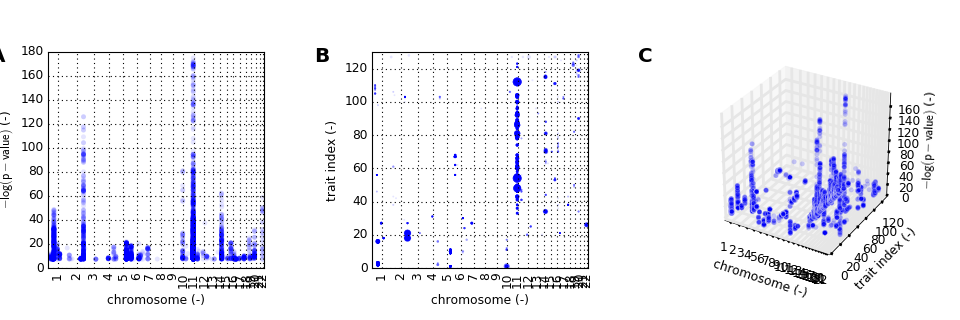

:Layout
   .PP_Chr.I       :Scatter   [chromosome]   ($\mathsf{-log(p-value)}$)
   .Trait_Chr.I    :Scatter   [chromosome]   (trait index,$\mathsf{-log(p-value)}$)
   .Trait_Chr_pP.I :Scatter3D   [chromosome,trait index]   ($\mathsf{-log(p-value)}$)

In [8]:
%%output backend='matplotlib:nbagg' holomap='widgets' widgets='live'
%%opts Scatter.pP_Chr (alpha=0.1,color='blue') [bgcolor='white',xticks=ChrTicks,xrotation=AxesDF.loc['MinorTickRotation','Chr'],show_title=False]
%%opts Scatter.Trait_Chr (alpha=0.1,color='blue') [bgcolor='white',scaling_factor=0.25,scaling_method='width',xticks=ChrTicks,xrotation=AxesDF.loc['MinorTickRotation','Chr'],show_title=False]
%%opts Scatter3D.Trait_Chr_pP [bgcolor='white',xticks=ChrTicks,xrotation=0,show_title=False] (alpha=0.1,edgecolor='white',color='blue')

Chromosome = holoviews.Dimension('chromosome', unit='-', range=(AxesDF.loc['Min','Chr'],AxesDF.loc['Max','Chr']))
TraitIndex = holoviews.Dimension('trait index', unit='-', range=(AxesDF.loc['Min','Trait'],AxesDF.loc['Max','Trait']))
pP = holoviews.Dimension(r'$\mathsf{-log(p-value)}$', unit='-', range=(AxesDF.loc['Min','pP'],AxesDF.loc['Max','pP']))

SPlot_pP_Chr = holoviews.DFrame(GWASummaryStatisticsDF[['MHPos',
                                                        'pP-value']],
                                dimensions={'MHPos':Chromosome,
                                            'pP-value':pP})
SPlot_Trait_Chr = holoviews.DFrame(GWASummaryStatisticsDF[['MHPos',
                                                           'TraitIndex',
                                                           'pP-value']],
                                   dimensions={'MHPos':Chromosome,
                                               'TraitIndex':TraitIndex,
                                               'pP-value':pP})
SPlot_Trait_Chr_pP = holoviews.DFrame(GWASummaryStatisticsDF[['MHPos',
                                                              'TraitIndex',
                                                              'pP-value']],
                                       dimensions={'MHPos':Chromosome,
                                                   'TraitIndex':TraitIndex,
                                                   'pP-value':pP})

(
    SPlot_pP_Chr.scatter(kdims='chromosome',
                         vdims=r'$\mathsf{-log(p-value)}$',
                         group='pP_Chr',
                         label='') 
    +
    SPlot_Trait_Chr.scatter(kdims='chromosome',
                            vdims=['trait index',
                                   r'$\mathsf{-log(p-value)}$'],
                            group='Trait_Chr',
                            label='') 
    +
    SPlot_Trait_Chr_pP.scatter3d(kdims=['chromosome',
                                        'trait index'],
                                 vdims=r'$\mathsf{-log(p-value)}$',
                                 group='Trait_Chr_pP',
                                 label='')
)

### Interactive plot of all data, allowing selection of `Trait` of interest:

:Layout
   .PP_Chr.I       :HoloMap   [Trait]
      :Scatter   [chromosome]   ($\mathsf{-log(p-value)}$)
   .Trait_Chr.I    :HoloMap   [Trait]
      :Scatter   [chromosome]   (trait index)
   .Trait_Chr_pP.I :HoloMap   [Trait]
      :Scatter3D   [chromosome,trait index]   ($\mathsf{-log(p-value)}$)
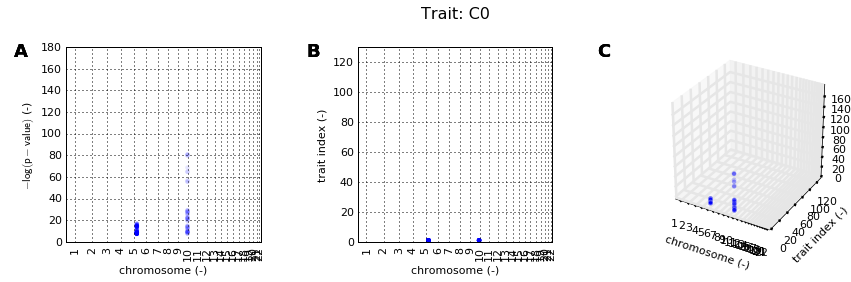

In [9]:
%%output backend='matplotlib' holomap='widgets' widgets='live'
%%opts Scatter.pP_Chr (alpha=0.1,color='blue') [bgcolor='white',xticks=ChrTicks,xrotation=AxesDF.loc['MinorTickRotation','Chr'],show_title=False]
%%opts Scatter.Trait_Chr (alpha=0.1,color='blue') [bgcolor='white',scaling_factor=0.25,scaling_method='width',xticks=ChrTicks,xrotation=AxesDF.loc['MinorTickRotation','Chr'],show_title=False]
%%opts Scatter3D.Trait_Chr_pP [bgcolor='white',xticks=ChrTicks,xrotation=0,show_title=False] (alpha=0.1,edgecolor='white',color='blue')

Chromosome = holoviews.Dimension('chromosome', unit='-', range=(AxesDF.loc['Min','Chr'],AxesDF.loc['Max','Chr']))
TraitIndex = holoviews.Dimension('trait index', unit='-', range=(AxesDF.loc['Min','Trait'],AxesDF.loc['Max','Trait']))
pP = holoviews.Dimension(r'$\mathsf{-log(p-value)}$', unit='-', range=(AxesDF.loc['Min','pP'],AxesDF.loc['Max','pP']))

SPlot_pP_Chr = holoviews.DFrame(GWASummaryStatisticsDF[['MHPos',
                                                        'pP-value',
                                                        'Trait']],
                                dimensions={'MHPos':Chromosome,
                                            'pP-value':pP})
SPlot_Trait_Chr = holoviews.DFrame(GWASummaryStatisticsDF[['MHPos',
                                                           'TraitIndex',
                                                           'Trait']],
                                   dimensions={'MHPos':Chromosome,
                                               'TraitIndex':TraitIndex})
SPlot_Trait_Chr_pP = holoviews.DFrame(GWASummaryStatisticsDF[['MHPos',
                                                              'TraitIndex',
                                                              'pP-value',
                                                              'Trait']],
                                       dimensions={'MHPos':Chromosome,
                                                   'TraitIndex':TraitIndex,
                                                   'pP-value':pP})

(
    SPlot_pP_Chr.scatter(kdims='chromosome',
                         vdims=r'$\mathsf{-log(p-value)}$',
                         mdims=['Trait'],
                         group='pP_Chr',
                         label='') 
    +
    SPlot_Trait_Chr.scatter(kdims='chromosome',
                            vdims='trait index',
                            mdims=['Trait'],
                            group='Trait_Chr',
                            label='') 
    +
    SPlot_Trait_Chr_pP.scatter3d(kdims=['chromosome',
                                        'trait index'],
                                 vdims=r'$\mathsf{-log(p-value)}$',
                                 mdims=['Trait'],
                                 group='Trait_Chr_pP',
                                 label='')
)

### Interactive plot of all data, allowing selection of `Class` of interest:

:Layout
   .PP_Chr.I       :HoloMap   [Class]
      :Scatter   [chromosome]   ($\mathsf{-log(p-value)}$)
   .Trait_Chr.I    :HoloMap   [Class]
      :Scatter   [chromosome]   (trait index)
   .Trait_Chr_pP.I :HoloMap   [Class]
      :Scatter3D   [chromosome,trait index]   ($\mathsf{-log(p-value)}$)
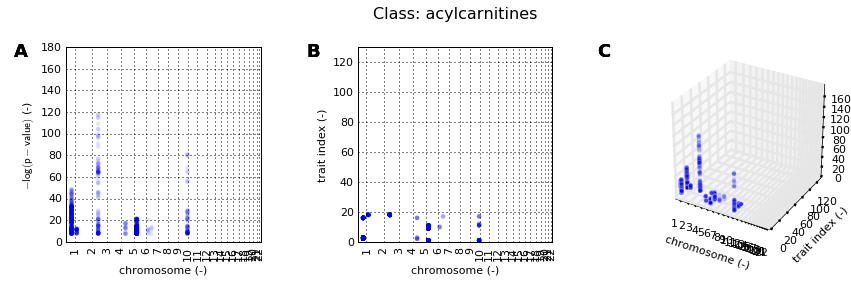

In [10]:
%%output backend='matplotlib' holomap='widgets'
%%opts Scatter.pP_Chr (alpha=0.1,color='blue') [bgcolor='white',xticks=ChrTicks,xrotation=AxesDF.loc['MinorTickRotation','Chr'],show_title=False]
%%opts Scatter.Trait_Chr (alpha=0.1,color='blue') [bgcolor='white',scaling_factor=0.25,scaling_method='width',xticks=ChrTicks,xrotation=AxesDF.loc['MinorTickRotation','Chr'],show_title=False]
%%opts Scatter3D.Trait_Chr_pP [bgcolor='white',xticks=ChrTicks,xrotation=0,show_title=False] (alpha=0.1,edgecolor='white',color='blue')

Chromosome = holoviews.Dimension('chromosome', unit='-', range=(AxesDF.loc['Min','Chr'],AxesDF.loc['Max','Chr']))
TraitIndex = holoviews.Dimension('trait index', unit='-', range=(AxesDF.loc['Min','Trait'],AxesDF.loc['Max','Trait']))
pP = holoviews.Dimension(r'$\mathsf{-log(p-value)}$', unit='-', range=(AxesDF.loc['Min','pP'],AxesDF.loc['Max','pP']))

SPlot_pP_Chr = holoviews.DFrame(GWASummaryStatisticsDF[['MHPos',
                                                        'pP-value',
                                                        'Class']],
                                dimensions={'MHPos':Chromosome,
                                            'pP-value':pP})
SPlot_Trait_Chr = holoviews.DFrame(GWASummaryStatisticsDF[['MHPos',
                                                           'TraitIndex',
                                                           'Class']],
                                   dimensions={'MHPos':Chromosome,
                                               'TraitIndex':TraitIndex})
SPlot_Trait_Chr_pP = holoviews.DFrame(GWASummaryStatisticsDF[['MHPos',
                                                              'TraitIndex',
                                                              'pP-value',
                                                              'Class']],
                                       dimensions={'MHPos':Chromosome,
                                                   'TraitIndex':TraitIndex,
                                                   'pP-value':pP})

(
    SPlot_pP_Chr.scatter(kdims='chromosome',
                         vdims=r'$\mathsf{-log(p-value)}$',
                         mdims=['Class'],
                         group='pP_Chr',
                         label='') 
    +
    SPlot_Trait_Chr.scatter(kdims='chromosome',
                            vdims='trait index',
                            mdims=['Class'],
                            group='Trait_Chr',
                            label='') 
    +
    SPlot_Trait_Chr_pP.scatter3d(kdims=['chromosome',
                                        'trait index'],
                                 vdims=r'$\mathsf{-log(p-value)}$',
                                 mdims=['Class'],
                                 group='Trait_Chr_pP',
                                 label='')
)

### Interactive plot of all data, allowing selection of `Trait` of interest within `Class` of interest:

:Layout
   .PP_Chr.I       :HoloMap   [Class,Trait]
      :Scatter   [chromosome]   ($\mathsf{-log(p-value)}$)
   .Trait_Chr.I    :HoloMap   [Class,Trait]
      :Scatter   [chromosome]   (trait index)
   .Trait_Chr_pP.I :HoloMap   [Class,Trait]
      :Scatter3D   [chromosome,trait index]   ($\mathsf{-log(p-value)}$)
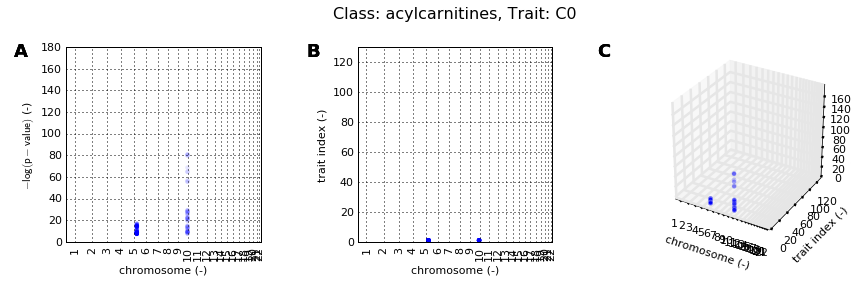

In [11]:
%%output backend='matplotlib' holomap='widgets'
%%opts Scatter.pP_Chr (alpha=0.1,color='blue') [bgcolor='white',xticks=ChrTicks,xrotation=AxesDF.loc['MinorTickRotation','Chr'],show_title=False]
%%opts Scatter.Trait_Chr (alpha=0.1,color='blue') [bgcolor='white',scaling_factor=0.25,scaling_method='width',xticks=ChrTicks,xrotation=AxesDF.loc['MinorTickRotation','Chr'],show_title=False]
%%opts Scatter3D.Trait_Chr_pP [bgcolor='white',xticks=ChrTicks,xrotation=0,show_title=False] (alpha=0.1,edgecolor='white',color='blue')

Chromosome = holoviews.Dimension('chromosome', unit='-', range=(AxesDF.loc['Min','Chr'],AxesDF.loc['Max','Chr']))
TraitIndex = holoviews.Dimension('trait index', unit='-', range=(AxesDF.loc['Min','Trait'],AxesDF.loc['Max','Trait']))
pP = holoviews.Dimension(r'$\mathsf{-log(p-value)}$', unit='-', range=(AxesDF.loc['Min','pP'],AxesDF.loc['Max','pP']))

SPlot_pP_Chr = holoviews.DFrame(GWASummaryStatisticsDF[['MHPos',
                                                        'pP-value',
                                                        'Class',
                                                        'Trait']],
                                dimensions={'MHPos':Chromosome,
                                            'pP-value':pP})
SPlot_Trait_Chr = holoviews.DFrame(GWASummaryStatisticsDF[['MHPos',
                                                           'TraitIndex',
                                                           'Class',
                                                           'Trait']],
                                   dimensions={'MHPos':Chromosome,
                                               'TraitIndex':TraitIndex})
SPlot_Trait_Chr_pP = holoviews.DFrame(GWASummaryStatisticsDF[['MHPos',
                                                              'TraitIndex',
                                                              'pP-value',
                                                              'Class',
                                                              'Trait']],
                                       dimensions={'MHPos':Chromosome,
                                                   'TraitIndex':TraitIndex,
                                                   'pP-value':pP})

(
    SPlot_pP_Chr.scatter(kdims='chromosome',
                         vdims=r'$\mathsf{-log(p-value)}$',
                         mdims=['Class',
                                'Trait'],
                         group='pP_Chr',
                         label='') 
    +
    SPlot_Trait_Chr.scatter(kdims='chromosome',
                            vdims='trait index',
                            mdims=['Class',
                                   'Trait'],
                            group='Trait_Chr',
                            label='') 
    +
    SPlot_Trait_Chr_pP.scatter3d(kdims=['chromosome',
                                        'trait index'],
                                 vdims=r'$\mathsf{-log(p-value)}$',
                                 mdims=['Class',
                                        'Trait'],
                                 group='Trait_Chr_pP',
                                 label='')
)